# IMDB Sentiment Analysis with LSTM

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
np.random.seed(42)
torch.manual_seed(42)

### Device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Pre-Processing and Preparation

### Loading

In [6]:
reviewsfname = "data/IMDB-Reviews.txt"
labelsfname = "data/IMDB-Labels.txt"

with open(reviewsfname, "r") as f:
    reviews = f.read()
    
with open(labelsfname, "r") as f:
    labels = f.read()
    
print(f"Reviews:\n{reviews[:1000]}")
print(f"\nLabels:\n{labels[:25]}")

Reviews:
bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audienc

### Cleanup

In [7]:
from string import punctuation

print(f"Punctuation: {punctuation}")

# Convert reviews to lowercase
reviews = reviews.lower()
labels = labels.lower()

# Remove punctuation
reviews = "".join([char for char in reviews if char not in punctuation])

Punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
allwords = reviews.split()

print(allwords[:10])

['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the']


Different reviews and labels are separated by newline characters in our dataset. Let's split the full text of reviews and labels into a list of reviews and labels:

In [9]:
reviews = reviews.split("\n")
labels = labels.split("\n")

In [10]:
# Check that we have the same number of reviews and labels
assert len(reviews) == len(labels)

print(reviews[:2])
print(labels[:2])

['bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t   ', 'story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned into an insane  viole

### Word Encoding

In [11]:
words = sorted(set(allwords))
n_words = len(words)

print(f"Number of unique words: {n_words}")
print(f"\n{words[:30]}")

Number of unique words: 74072

['a', 'aa', 'aaa', 'aaaaaaah', 'aaaaah', 'aaaaatch', 'aaaahhhhhhh', 'aaaand', 'aaaarrgh', 'aaah', 'aaargh', 'aaaugh', 'aaawwwwnnn', 'aachen', 'aada', 'aadha', 'aag', 'aage', 'aaghh', 'aah', 'aahhh', 'aaip', 'aaja', 'aakash', 'aaker', 'aakrosh', 'aaliyah', 'aames', 'aamir', 'aan']


In [12]:
# Create word to int mapping with 1 as first index
word2int = {word : i for i, word in enumerate(words, 1)}

# Create inverse int to word mapping
int2word = {i : word for word, i in word2int.items()}

# Check conversion
assert len(word2int) == len(int2word)
for word in words:
    assert word == int2word[word2int[word]]

In [13]:
encodedreviews = []
for review in reviews:
    encodedreviews.append([word2int[word] for word in review.split()])

# Visualize and check encoding
print(f"Reviw 1:\n{reviews[0].split()[:5]}")
print(f"\nEncoded Review 1:\n{encodedreviews[0][:5]}")
print(f"\nEncoding:\n")
for word in reviews[0].split()[:5]:
    print(f"{word:12} => {word2int[word]}")
    
encodedreviews = np.array(encodedreviews)
print(f"\nEncoded Revies Shape: {encodedreviews.shape}")

Reviw 1:
['bromwell', 'high', 'is', 'a', 'cartoon']

Encoded Review 1:
[8210, 29951, 33665, 1, 9819]

Encoding:

bromwell     => 8210
high         => 29951
is           => 33665
a            => 1
cartoon      => 9819

Encoded Revies Shape: (25001,)


### Label Encoding

In [14]:
encodedlabels = []
for label in labels:
    encodedlabels.append(0 if label == "negative" else 1)
    
# Visualize and check labels
print(f"Labels:\n{labels[:5]}")
print(f"\nEncoded Labels:\n{encodedlabels[:5]}")

# Transform labels to numpy array
encodedlabels = np.array(encodedlabels)

Labels:
['positive', 'negative', 'positive', 'negative', 'positive']

Encoded Labels:
[1, 0, 1, 0, 1]


### Very Short and Very Long Review

In [15]:
reviewlenghts = [len(review) for review in encodedreviews]

reviewlenghts = np.array(reviewlenghts)

print(f"Minimum Review Length: {np.min(reviewlenghts)}")
print(f"Maximum Review Length: {np.max(reviewlenghts)}")
print(f"Average Review Length: {np.mean(reviewlenghts):.3f}")
print(f"Review Length STD: {np.std(reviewlenghts):.3f}")

Minimum Review Length: 0
Maximum Review Length: 2514
Average Review Length: 240.798
Review Length STD: 179.017


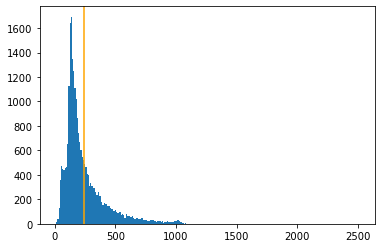

In [16]:
plt.figure()
plt.hist(reviewlenghts, bins=len(reviewlenghts)//100)
plt.axvline(np.mean(reviewlenghts), color="orange", )
plt.show()

Let's have a look at the very short reviews:

In [17]:
idxs = np.where(reviewlenghts <= 15)[0]

for idx in idxs:
    print(reviews[idx], end="\n\n")

this movie is terrible but it has some good effects   

ming the merciless does a little bardwork and a movie most foul   

comment this movie is impossible  is terrible  very improbable  bad interpretation e direction  not look       

i wouldn  t rent this one even on dollar rental night   

you  d better choose paul verhoeven  s even if you have watched it   

adrian pasdar is excellent is this film  he makes a fascinating woman   

no comment  stupid movie  acting average or worse    screenplay  no sense at all    skip it   

long  boring  blasphemous  never have i been so glad to see ending credits roll   





In [18]:
encodedreviews = encodedreviews[reviewlenghts > 0] 
encodedlabels = encodedlabels[reviewlenghts > 0]

print(f"Encoded Reviews Shape: {encodedreviews.shape}")
print(f"Encoded Labels Shape: {encodedlabels.shape}")

Encoded Reviews Shape: (25000,)
Encoded Labels Shape: (25000,)


### Truncation and Padding

In [19]:
len_sequence = 256 # Total number of word in a review

paddedreviews = np.zeros((encodedreviews.size, len_sequence), dtype=int)

for i, review in enumerate(encodedreviews):
    paddedreviews[i,-len(review):] = review[:len_sequence]
    
print(paddedreviews)

[[    0     0     0 ... 33768 33726 64394]
 [    0     0     0 ...  5272 57783  8031]
 [30468 46281 30894 ...  7193 41074 46549]
 ...
 [    0     0     0 ... 15007 60837  4144]
 [    0     0     0 ... 46549 71568 25211]
 [    0     0     0 ... 65773 33665 47191]]


### Training, Validation and Test Splits

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
reviews_train, reviews_vt, labels_train, labels_vt = train_test_split(paddedreviews, encodedlabels, test_size=0.2)
print(f"Reviews Train: {reviews_train.shape}\nLabels Train: {labels_train.shape}")

Reviews Train: (20000, 256)
Labels Train: (20000,)


In [22]:
reviews_valid, reviews_test, labels_valid, labels_test = train_test_split(reviews_vt, labels_vt, test_size=0.5)
print(f"Reviews Valid: {reviews_valid.shape}\nLabels Valid: {labels_valid.shape}")
print(f"Reviews Test: {reviews_test.shape}\nLabels Test: {labels_test.shape}")

Reviews Valid: (2500, 256)
Labels Valid: (2500,)
Reviews Test: (2500, 256)
Labels Test: (2500,)


### Data Loaders and Batches

In [23]:
trainset = TensorDataset(torch.from_numpy(reviews_train), torch.from_numpy(labels_train))
validset = TensorDataset(torch.from_numpy(reviews_valid), torch.from_numpy(labels_valid))
testset = TensorDataset(torch.from_numpy(reviews_test), torch.from_numpy(labels_test))

batch_size = 64

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size, drop_last=True)
validloader = DataLoader(validset, shuffle=True, batch_size=batch_size, drop_last=True)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size, drop_last=True)

In [24]:
trainiter = iter(trainloader)

features, labels = next(trainiter)

print(f"Features Shape: {features.shape}")
print(f"Features:\n{features}")
print(f"Labels Shape: {labels.shape}")
print(f"Labels:\n{labels}")

Features Shape: torch.Size([64, 256])
Features:
tensor([[    0,     0,     0,  ..., 25370, 71489, 33768],
        [31424, 55987,     1,  ...,  7681,  7681, 49515],
        [31424, 26653, 65773,  ...,  2477, 65543, 52123],
        ...,
        [    0,     0,     0,  ..., 10351, 45177, 33768],
        [    0,     0,     0,  ..., 29251, 29037, 63296],
        [61400, 38692, 65543,  ...,  4002, 45809, 65543]])
Labels Shape: torch.Size([64])
Labels:
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0])


## LSTM Sentiment Analysis

### LSTM Architecture

In [25]:
class SentimentRNN(nn.Module):
    
    def __init__(self, 
                 n_words, # Number of words 
                 s_embedding, # Embedding size
                 s_hidden, # Hidden layer size
                 n_layers, # Number of LSTM layers
                 dropp=0.5 # Dropout probability
                ):
        
        super().__init__()
        
        n_words += 1 # Add one word for 0 padding
        
        self.s_hidden = s_hidden
        
        # Embedding layer to avoid one-hot-encoding all words
        # Reduce n_words to s_embedding for LSTM input
        self.embedding = nn.Embedding(n_words, s_embedding)
        
        # Define LSTM layer with embedding input
        self.lstm = nn.LSTM(s_embedding, s_hidden, n_layers, dropout=dropp, batch_first=True)
        
        # Define dropout layer between LSTM and FC
        self.dropout = nn.Dropout(0.25)
        
        # Fully connected layer with one output
        # One ouptut for binary classification (positive/negative)
        self.fc = nn.Linear(s_hidden, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        
        batch_size = x.shape[0]
        
        x = self.embedding(x)
        
        x, hidden = self.lstm(x, hidden)
        
        x = x.reshape(-1, self.s_hidden)
        
        x = self.dropout(x)
        
        x = self.fc(x)
        
        # Apply sigmoid function
        # Returns values between 0 and 1
        x = self.sigmoid(x)
        
        # Respahe
        x = x.reshape(batch_size, -1)
        
        # Get last batch
        x = x[:, -1]
        
        return x, hidden

###  Training

In [26]:
s_embedding = 500
s_hidden = 256
n_layers = 2

model = SentimentRNN(n_words, s_embedding, s_hidden, n_layers)

model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(74073, 500)
  (lstm): LSTM(500, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [27]:
lr=0.005

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [28]:
epochs = 5
print_every = len(trainloader) // 2

model.train()

steps = 0
for epoch in range(epochs):
    
    hidden = None
    
    for review, label in trainloader:
        
        steps += 1
        
        # Reset optimizer gradients
        optimizer.zero_grad()
        
        review, label = review.to(device), label.to(device)
        
        output, hidden = model(review, hidden)
        
        hidden = tuple([h.detach() for h in hidden])
        
        loss = loss_function(output.squeeze(), label.float())
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        optimizer.step()
        
        if steps % print_every == 0:
            
            model.eval()
            
            with torch.no_grad():
                
                hidden_v = None
                
                loss_v = 0
                
                for rewiev, label in validloader:
                    
                    review, label = review.to(device), label.to(device)
                    
                    output, hidden_v = model(review, hidden_v)
                    
                    loss_v += loss_function(output.squeeze(), label.float()).item()
                    
            print(f"--- Epoch {epoch}/{epochs}")
            print(f"    Step: {steps}")
            print(f"    Validation Loss: {loss_v/len(validloader):.5f}")
                    
            model.train()

--- Epoch 0/5
    Step: 156
    Validation Loss: 0.97895
--- Epoch 0/5
    Step: 312
    Validation Loss: 0.99879
--- Epoch 1/5
    Step: 468
    Validation Loss: 1.83703
--- Epoch 1/5
    Step: 624
    Validation Loss: 1.77770
--- Epoch 2/5
    Step: 780
    Validation Loss: 1.75985
--- Epoch 2/5
    Step: 936
    Validation Loss: 1.71410
--- Epoch 3/5
    Step: 1092
    Validation Loss: 2.28626
--- Epoch 3/5
    Step: 1248
    Validation Loss: 2.29612
--- Epoch 4/5
    Step: 1404
    Validation Loss: 2.86544
--- Epoch 4/5
    Step: 1560
    Validation Loss: 2.77071


### Test

In [29]:
model.eval()

SentimentRNN(
  (embedding): Embedding(74073, 500)
  (lstm): LSTM(500, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [43]:
testscores = -np.ones((len(testloader) * batch_size,))
testlabels = -np.ones((len(testloader) * batch_size,))

with torch.no_grad():
    
    hidden_t = None
    
    loss_t = 0
    
    n_correct = 0
    
    for i, (review, label) in enumerate(testloader):
        
        assert review.shape == (batch_size, len_sequence)
        
        review, label = review.to(device), label.to(device)
                    
        output, hidden_v = model(review, hidden_v)
                    
        loss_t += loss_function(output.squeeze(), label.float()).item()
        
        testscores[i*batch_size:(i+1)*batch_size] = output.squeeze().cpu()
        testlabels[i*batch_size:(i+1)*batch_size] = label.squeeze().cpu()
    
        # Compute predictions by rounding to 0 or 1
        predictions = torch.round(output.squeeze())
        
        correct = predictions == label.float().view_as(predictions)
        
        correct = correct.squeeze().cpu().numpy()
        
        n_correct += np.sum(correct)
        
print(f"Test Loss: {loss_t / len(testloader):.5f}")
print(f"Accuracy: {n_correct / (len(testloader) * batch_size) * 100:.2f}")

Test Loss: 0.48547
Accuracy: 86.62


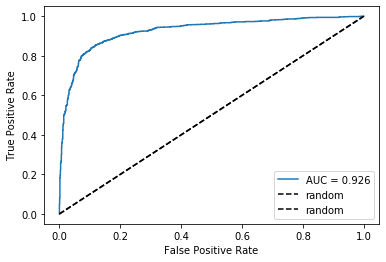

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(testlabels, testscores)

AUC = roc_auc_score(testlabels, testscores)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {AUC:.3f}")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), "k--", label="random")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), "k--", label="random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

### Inference

In [109]:
def review_to_tokens(review, len_sequence):
    from string import punctuation

    review = review.lower()
    
    review = "".join([char for char in review if char not in punctuation])
    
    review = np.array(review.split())
    
    encodedreview = [[word2int[word] for word in review]]
    
    paddedreview = np.zeros((1, len_sequence), dtype=int)
    paddedreview[:,-len(review):] = encodedreview[:len_sequence]
        
    return paddedreview

In [110]:
paddedreview = review_to_tokens("The film was epic!", len_sequence)

assert paddedreview.shape == (1, len_sequence)

print(paddedreview)

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0 